# CITS5017 Project 1
Kaylee Molin (22734429)

---

### Importing Relevant Packages

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical # FIX ask if this is allowed

In [18]:
(X_train_original, y_train_original), (X_test_original, y_test_original) = tf.keras.datasets.cifar10.load_data()
assert X_train_original.shape == (50000, 32, 32, 3)
assert X_test_original.shape == (10000, 32, 32, 3)
assert y_train_original.shape == (50000, 1)
assert y_test_original.shape == (10000, 1)

### Normalising the pixel values to be between 0 and 1

In [19]:
X_train_norm, X_test = X_train_original/255.0, X_test_original/255.0
y_test=y_test_original

In [20]:
X_train_norm

array([[[[0.23137255, 0.24313725, 0.24705882],
         [0.16862745, 0.18039216, 0.17647059],
         [0.19607843, 0.18823529, 0.16862745],
         ...,
         [0.61960784, 0.51764706, 0.42352941],
         [0.59607843, 0.49019608, 0.4       ],
         [0.58039216, 0.48627451, 0.40392157]],

        [[0.0627451 , 0.07843137, 0.07843137],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509804, 0.21568627],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117647, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215686, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941176, 0.19607843],
         [0.47058824, 0.32941176, 0.19607843],
         [0.42745098, 0.28627451, 0.16470588]],

        ...,

        [[0.81568627, 0.66666667, 0.37647059],
         [0.78823529, 0.6       , 0.13333333]

### (i) Forming a validation set form the training set

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train_norm, y_train_original, test_size=0.15, random_state=22, stratify=y_train_original)
# Print the shapes of the resulting datasets
print("Training set shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nValidation set shapes:")
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("\nTest set shapes:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Training set shapes:
X_train: (42500, 32, 32, 3)
y_train: (42500, 1)

Validation set shapes:
X_val: (7500, 32, 32, 3)
y_val: (7500, 1)

Test set shapes:
X_test: (10000, 32, 32, 3)
y_test: (10000, 1)


### (ii) Function to display 20 randomly sampled images

In [6]:
def display_random_subset(X, y, class_names, title):
    plt.figure(figsize=(12, 6))
    indices = np.random.randint(0, len(X), size=20)
    
    for i, index in enumerate(indices):
        plt.subplot(4, 5, i+1)
        plt.imshow(X[index])
        plt.title(class_names[y[index][0]])
        plt.axis('off')
    
    plt.suptitle(title, fontsize=16)  # Adding a title to the entire figure
    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjusting layout for the title
    plt.show()


In [7]:
# Load class names from TFDS
dataset_info = tfds.builder("cifar10")
class_names = dataset_info.info.features["label"].names

2023-08-25 22:37:06.001446: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


### Displaying 20 random images from the training set

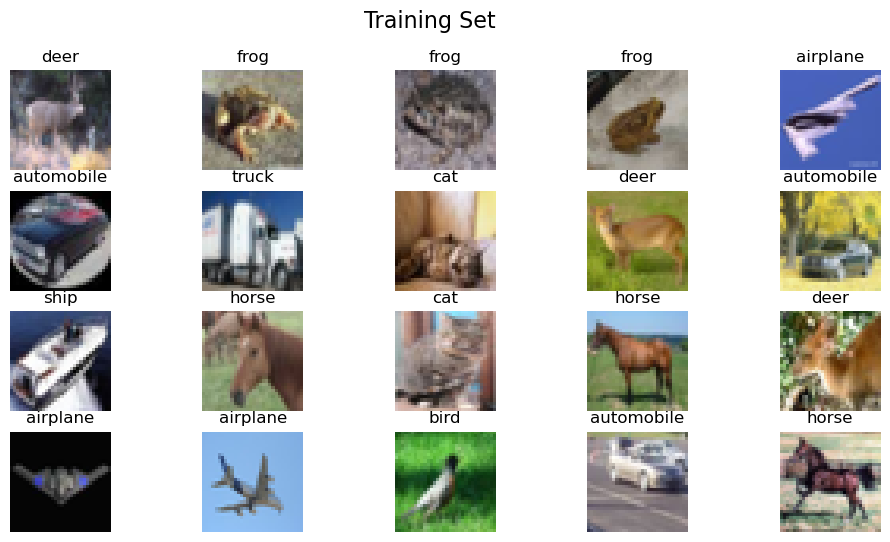

In [8]:
display_random_subset(X_train, y_train, class_names, "Training Set")

### Displaying 20 random images from the validation set

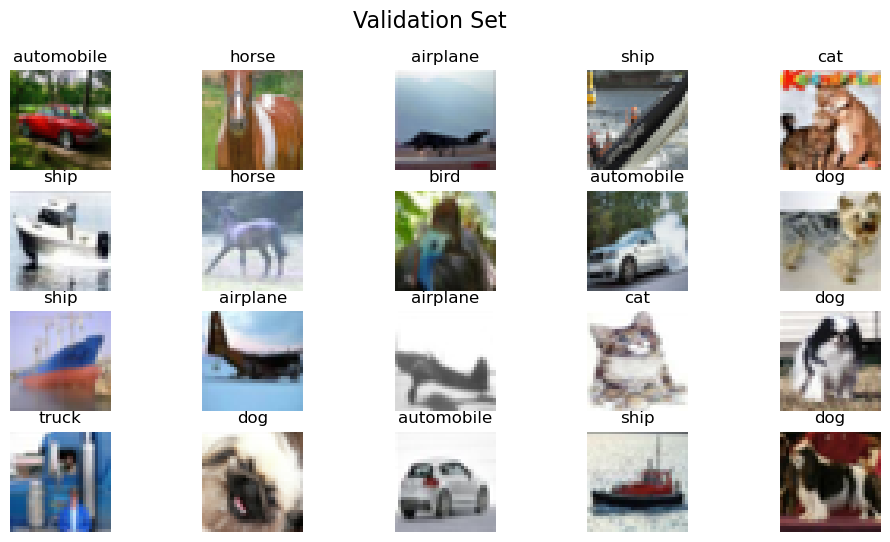

In [9]:
display_random_subset(X_val, y_val, class_names, "Validation Set")

### Displaying 20 random images from the testing set

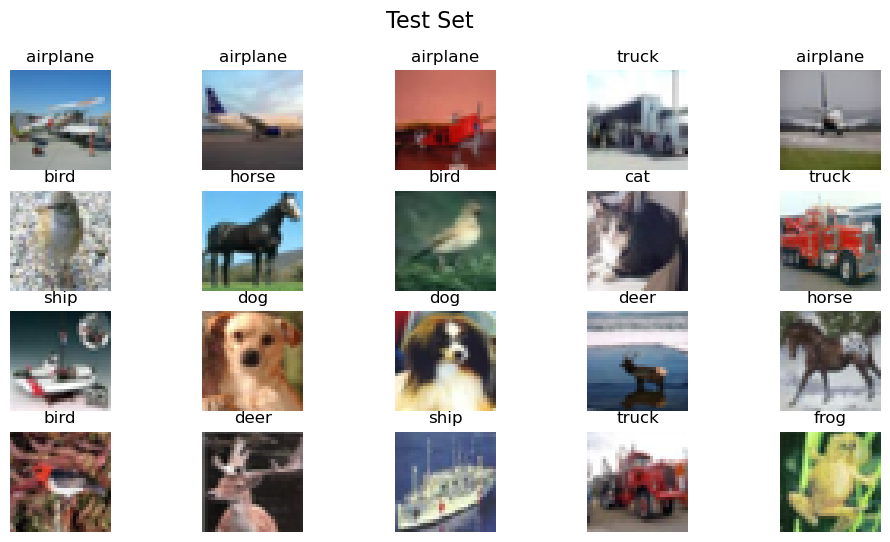

In [10]:
display_random_subset(X_test, y_test, class_names, "Test Set")

In [11]:
# ds, ds_info = tfds.load('cifar10', split='train', with_info=True)
# fig = tfds.show_examples(ds, ds_info)

In [12]:
# Get the number of classes
num_classes = len(class_names)

y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

In [13]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((42500, 32, 32, 3), (10000, 32, 32, 3), (42500, 10), (10000, 10))

### (iii) Training an MLP

In [14]:
# Get the number of classes
# num_classes = len(class_names)

# Create the MLP model
model_mlp = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[32, 32, 3]),
    #tf.keras.layers.Dense(1024, activation='relu'),  
    tf.keras.layers.Dense(1000, activation='relu'),
    #tf.keras.layers.Dense(1000, activation='relu'),   
    tf.keras.layers.Dense(500, activation='relu'),   
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer with num_classes units and softmax activation
])

# optimizer=tf.keras.optimizers.legacy.Adam()

# Compile the model
model_mlp.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Defining the early stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model_mlp.fit(X_train, y_train, epochs=100,batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

model_mlp.summary()


2023-08-25 22:37:20.058811: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-08-25 22:37:20.058836: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-25 22:37:20.058843: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-25 22:37:20.058886: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-25 22:37:20.058912: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2023-08-25 22:37:21.151883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: 6.7562 - accuracy: 0.1551

2023-08-25 22:37:47.243038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 29s 21ms/step - loss: 6.7562 - accuracy: 0.1551 - val_loss: 5.9883 - val_accuracy: 0.1512
Epoch 2/100
1329/1329 [==============================] - 28s 21ms/step - loss: 7.4053 - accuracy: 0.1624 - val_loss: 13.8031 - val_accuracy: 0.1508
Epoch 3/100
1329/1329 [==============================] - 29s 22ms/step - loss: 8.1781 - accuracy: 0.1663 - val_loss: 16.5419 - val_accuracy: 0.1576
Epoch 4/100
1329/1329 [==============================] - 29s 21ms/step - loss: 8.5047 - accuracy: 0.1708 - val_loss: 14.4103 - val_accuracy: 0.1476
Epoch 5/100
1329/1329 [==============================] - 31s 23ms/step - loss: 8.7876 - accuracy: 0.1671 - val_loss: 11.5424 - val_accuracy: 0.1384
Epoch 6/100
1329/1329 [==============================] - 28s 21ms/step - loss: 8.9736 - accuracy: 0.1728 - val_loss: 24.3154 - val_accuracy: 0.1005
Epoch 7/100
1329/1329 [==============================] - 29s 22ms/step - loss: 9.0180 - accuracy: 0.1710 - val_loss: 16.5628 

KeyboardInterrupt: 

# https://github.com/adameksopot/MLP-for-Cifar10-/blob/master/MLP.ipynb
# try this! very good accuracy

In [ ]:
# Hyperparameters to experiment with
weight_initializations = ['glorot_uniform', 'he_normal'] # read https://keras.io/api/layers/initializers/ for more initialisers
dropout_rates = [0.2, 0.4]

for weight_init in weight_initializations:
    for dropout_rate in dropout_rates:
        # Create the MLP model with hyperparameters
        model = Sequential([
            Flatten(input_shape=input_shape),
            Dense(512, activation='relu', kernel_initializer=weight_init),
            Dropout(dropout_rate),
            Dense(256, activation='relu', kernel_initializer=weight_init),
            Dropout(dropout_rate),
            Dense(num_classes, activation='softmax')
        ])

        # Compile the model
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

        # Define early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Train the model with early stopping on the validation set
        history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

        # Evaluate the model on the test set
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
        
        # Print results for each combination of hyperparameters
        print(f"Weight Init: {weight_init}, Dropout Rate: {dropout_rate}")
        print("Test accuracy:", test_accuracy)
        print("-" * 40)

## CNN

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

num_classes = 10
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 64
epochs = 10
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=2)
print("\nTest accuracy:", test_accuracy)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 15, 15, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                      

2023-08-25 23:29:04.558558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


665/665 [==============================] - ETA: 0s - loss: 1.4940 - accuracy: 0.4686

2023-08-25 23:29:20.190954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


665/665 [==============================] - 17s 22ms/step - loss: 1.4940 - accuracy: 0.4686 - val_loss: 2.0520 - val_accuracy: 0.3452
Epoch 2/10
665/665 [==============================] - 13s 19ms/step - loss: 1.2939 - accuracy: 0.5420 - val_loss: 2.1949 - val_accuracy: 0.3640
Epoch 3/10
665/665 [==============================] - 11s 17ms/step - loss: 1.2626 - accuracy: 0.5606 - val_loss: 2.5755 - val_accuracy: 0.3367
Epoch 4/10
665/665 [==============================] - 12s 19ms/step - loss: 1.2861 - accuracy: 0.5638 - val_loss: 4.0308 - val_accuracy: 0.1684
Epoch 5/10
665/665 [==============================] - 12s 19ms/step - loss: 1.2954 - accuracy: 0.5639 - val_loss: 1.8075 - val_accuracy: 0.4628
Epoch 6/10
665/665 [==============================] - 13s 20ms/step - loss: 1.3707 - accuracy: 0.5512 - val_loss: 2.2121 - val_accuracy: 0.4276
Epoch 7/10
665/665 [==============================] - 15s 23ms/step - loss: 1.4615 - accuracy: 0.5403 - val_loss: 2.5434 - val_accuracy: 0.4201
Epo